In [1]:
import qiskit
import numpy as np
import matplotlib.pylab as plt

from qiskit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit.synthesis import (
    SuzukiTrotter,
    LieTrotter,
)

In [2]:
n_site = 3
n_qubits = 4
const_T = 1
a = 1
k = np.linspace(-3.14/a,+3.14/a,n_site)

epsilon = 0
Ek = -2*const_T*np.cos(k*a)
V = 4
print(k)


[-3.14  0.    3.14]


In [3]:

hamiltonian = SparsePauliOp(['IIII','ZIII','IZII','IIZI','IIIZ','XXII','YYII'],[epsilon + np.sum(Ek),epsilon,Ek[0],Ek[1],Ek[2],V/4,V/4])
b_dag_op = SparsePauliOp(['XIII','YIII'],[1/2,1.j/2])
b_op = SparsePauliOp(['XIII','YIII'],[1/2,-1.j/2])
 
X_op= SparsePauliOp(['XIII'],[1])
Y_op = SparsePauliOp(['YIII'],[1])

print(b_dag_op, b_op)
print(X_op,Y_op)

SparsePauliOp(['XIII', 'YIII'],
              coeffs=[0.5+0.j , 0. +0.5j]) SparsePauliOp(['XIII', 'YIII'],
              coeffs=[0.5+0.j , 0. -0.5j])
SparsePauliOp(['XIII'],
              coeffs=[1.+0.j]) SparsePauliOp(['YIII'],
              coeffs=[1.+0.j])


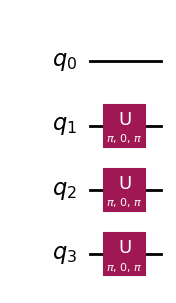

In [4]:
qc = QuantumCircuit(4)
qc.x(3)
qc.x(2)
qc.x(1)
psi = Statevector(qc)
qc.decompose().draw(output='mpl')

In [5]:
print(psi.draw('latex_source'))


 |1110\rangle


In [6]:
num_timesteps = 20
evolution_time = 10.0
dt = evolution_time / num_timesteps
product_formula_lt = LieTrotter()

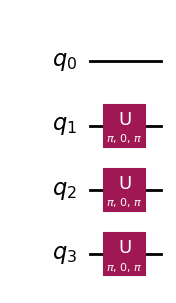

In [7]:
initial_circuit = QuantumCircuit(n_qubits)
initial_circuit.prepare_state("1110")
# Change reps and see the difference when you decompose the circuit
initial_circuit.decompose(reps=2).draw("mpl")


Trotter step with Lie-Trotter
-----------------------------
Depth: 15
Gate count: 26
Nonlocal gate count: 4
Gate breakdown: U: 8, CX: 4, S: 4, H: 4, SDG: 4, P: 2



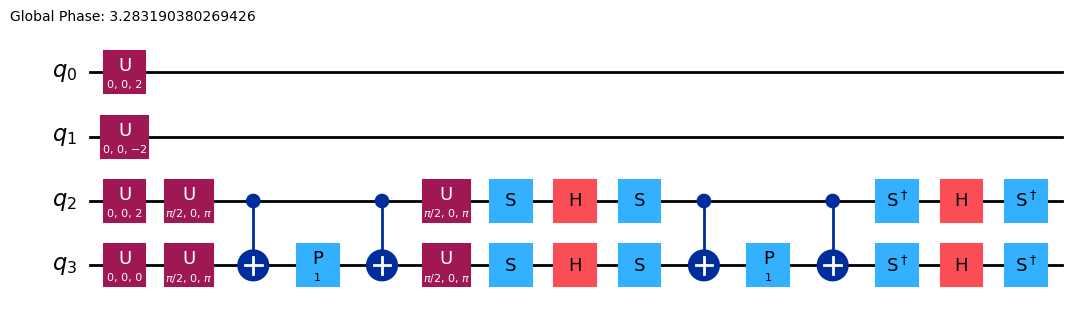

In [8]:
single_step_evolution_gates_lt = PauliEvolutionGate(
    hamiltonian, dt, synthesis=product_formula_lt
)
single_step_evolution_lt = QuantumCircuit(n_qubits)
single_step_evolution_lt.append(
    single_step_evolution_gates_lt, single_step_evolution_lt.qubits
)
 
print(
    f"""
Trotter step with Lie-Trotter
-----------------------------
Depth: {single_step_evolution_lt.decompose(reps=3).depth()}
Gate count: {len(single_step_evolution_lt.decompose(reps=3))}
Nonlocal gate count: {single_step_evolution_lt.decompose(reps=3).num_nonlocal_gates()}
Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in single_step_evolution_lt.decompose(reps=3).count_ops().items()])}
"""
)
single_step_evolution_lt.decompose(reps=3).draw("mpl", fold=-1)

In [9]:
# Apply b† to prepare |Φ⟩
# Since b† = (X - iY)/2 is non-unitary,
# we prepare its action using just the X-part for the state:

# Initiate the circuit
evolved_state = QuantumCircuit(initial_circuit.num_qubits)
# Start from the initial spin configuration
evolved_state.append(initial_circuit, evolved_state.qubits)
evolved_state.x(0)
# Initiate Estimator (V2)
estimator = StatevectorEstimator()
# Set number of shots
shots = 10000
# Translate the precision required from the number of shots
precision = np.sqrt(1 / shots)
G_list = []
# Estimate expectation values for t=0.0
# job = estimator.run(
#     [(evolved_state, [hamiltonian, magnetization, correlation])], precision=precision
# )

job = estimator.run(
    [(evolved_state, [X_op,Y_op])],
    precision=precision
)

evs = job.result()[0].data.evs
G0 = 0.5 * (evs[0] + 1j * evs[1])
G_list.append(G0)
# Start time evolution
for n in range(num_timesteps):
    # Expand the circuit to describe delta-t
    evolved_state.append(single_step_evolution_gates_lt, evolved_state.qubits)
    psi = Statevector(evolved_state)
    print(psi.draw('latex_source'))
    # Estimate expectation values at delta-t
    job = estimator.run(
        [(evolved_state, [X_op,Y_op])],
        precision=precision,
    )
    # Retrieve results (expectation values)
    evs = job.result()[0].data.evs
    Gt = 0.5 * (evs[0] + 1j * evs[1])
    G_list.append(Gt)

# Transform the list of expectation values (at each time step) to arrays
G_array = np.array(G_list)


/home/takshit/miniconda3/envs/qiskit-latest-env/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/takshit/miniconda3/envs/qiskit-latest-env/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


 |1111\rangle
 |1111\rangle
 |1111\rangle
 |1111\rangle
 |1111\rangle
 |1111\rangle
 |1111\rangle
 |1111\rangle
 |1111\rangle
 |1111\rangle
 |1111\rangle
 |1111\rangle
 |1111\rangle
 |1111\rangle
 |1111\rangle
 |1111\rangle
 |1111\rangle
 |1111\rangle
 |1111\rangle
 |1111\rangle


Text(0, 0.5, '|G|^2')

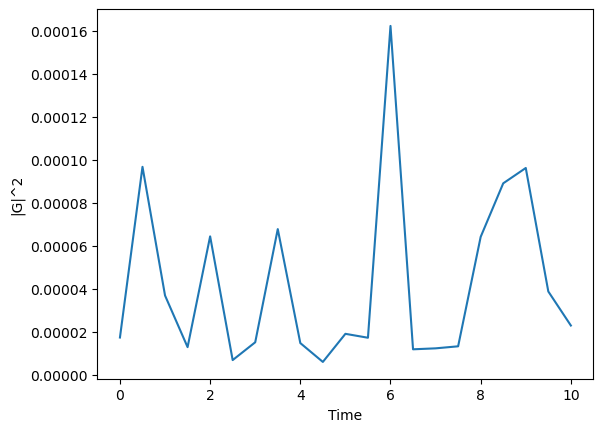

In [10]:
G_abs_sqr = np.abs(G_array)**2
plt.figure()
times = np.linspace(0, evolution_time, num_timesteps + 1)  # includes initial state
plt.plot(times, G_abs_sqr)
plt.xlabel("Time")
plt.ylabel("|G|^2")